# Carregando os dados

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [20]:
%%time
transactions_2009_2010 = pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2009-2010", engine='openpyxl')
transactions_2010_2011= pd.read_excel('../online_retail_II.xlsx',sheet_name="Year 2010-2011", engine='openpyxl')

CPU times: total: 2min 26s
Wall time: 2min 38s


In [21]:
# Concatenar os DataFrames (empilhar as linhas)
transactions = pd.concat([transactions_2009_2010, transactions_2010_2011], ignore_index=True)

# Exibir as primeiras linhas do DataFrame combinado
print(transactions.shape)

(1067371, 8)


In [22]:
transactions.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


([<matplotlib.axis.YTick at 0x220b32e8970>,
 [Text(0, 0, 'Invoice'),
  Text(0, 1, 'StockCode'),
  Text(0, 2, 'Description'),
  Text(0, 3, 'Quantity'),
  Text(0, 4, 'InvoiceDate'),
  Text(0, 5, 'Price'),
  Text(0, 6, 'Customer ID'),
  Text(0, 7, 'Country')])

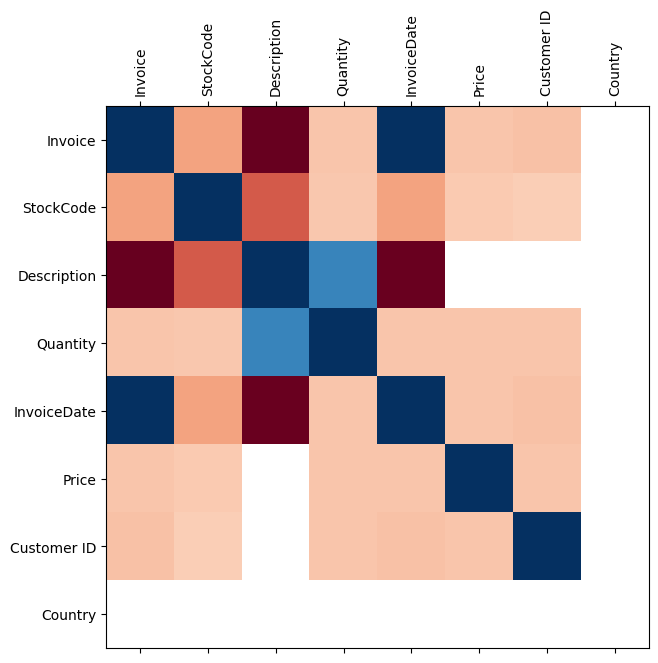

In [24]:
# Análise de correlação de dados
# Convert all columns to numeric, replacing errors with NaN
df = transactions.apply(pd.to_numeric, errors='coerce')
correlation = df.corr()
fig = plt.figure(figsize=(7,7))
plt.matshow(correlation, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation='vertical')
plt.yticks(range(len(correlation.columns)), correlation.columns)

# Limpeza de Dados

In [25]:
# Verificando valores ausentes
transactions.isna().sum()

# transactions['isCancelled'] = transactions['Invoice'][0]

# Verificando valores númericos
transactions['Invoice'] = pd.to_numeric(transactions['Invoice'], errors='coerce')

transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'])

# Análise de Dados Básicos

In [26]:
# Adiciona a coluna ano
transactions['ano'] = transactions['InvoiceDate'].dt.year

transactions['mes'] = transactions['InvoiceDate'].dt.month

transactions['dia'] = transactions['InvoiceDate'].dt.day

transactions['semana_mes'] = transactions['InvoiceDate'].dt.isocalendar().week

# Remove as transações canceladas
transactions_filtered = transactions[~transactions['Invoice'].astype(str).str.contains('C', na=False)]

# Agrupoar por produto e somar as quantidades vendidas
top_products = transactions_filtered.groupby('Description')['Quantity'].sum().reset_index()

# Ordenar do mais vendido para o menos vendido
top_products = top_products.sort_values(by='Quantity', ascending=False)

# Mostra os 10 produtos mais vendidos nos 4 anos
print(top_products.head(10))

                             Description  Quantity
5388   WORLD WAR 2 GLIDERS ASSTD DESIGNS    108545
5266  WHITE HANGING HEART T-LIGHT HOLDER     93050
328        ASSORTED COLOUR BIRD ORNAMENT     81306
2508             JUMBO BAG RED RETROSPOT     78090
801                  BROCADE RING PURSE      70700
3204  PACK OF 60 PINK PAISLEY CAKE CASES     56575
168          60 TEATIME FAIRY CAKE CASES     54366
4706                SMALL POPCORN HOLDER     49616
3207     PACK OF 72 RETROSPOT CAKE CASES     49344
3206    PACK OF 72 RETRO SPOT CAKE CASES     46106


In [27]:
# Mostrar o total de vendas
transactions_filtered['Invoice'].unique().shape[0]

45331

# Total de vendas por tempo(diário, semanal, mensal)

In [28]:
# Total de vendas por ano
transactions_by_year = transactions_filtered.groupby('ano', as_index=False)['Quantity'].sum()

print(transactions_by_year)

    ano  Quantity
0  2009    420088
1  2010   5354181
2  2011   4834223


In [29]:
# Total de vendas por mês
transactions_by_month = transactions_filtered.groupby(['ano','mes'], as_index=False)['Quantity'].sum()

print(transactions_by_month)

     ano  mes  Quantity
0   2009   12    420088
1   2010    1    375363
2   2010    2    368402
3   2010    3    489370
4   2010    4    351971
5   2010    5    364095
6   2010    6    388253
7   2010    7    302201
8   2010    8    451803
9   2010    9    478262
10  2010   10    601729
11  2010   11    673856
12  2010   12    508876
13  2011    1    308966
14  2011    2    277989
15  2011    3    351872
16  2011    4    289098
17  2011    5    380391
18  2011    6    341623
19  2011    7    391116
20  2011    8    406199
21  2011    9    549817
22  2011   10    570532
23  2011   11    740286
24  2011   12    226334


In [30]:
# Total de vendas semanal
transactions_by_week = transactions_filtered.groupby(['ano', 'mes', 'semana_mes'], as_index=False)['Quantity'].sum()

print(transactions_by_week)

      ano  mes  semana_mes  Quantity
0    2009   12          49    136455
1    2009   12          50    111826
2    2009   12          51    133295
3    2009   12          52     38512
4    2010    1           1     92971
..    ...  ...         ...       ...
116  2011   11          46    179216
117  2011   11          47    162568
118  2011   11          48     85640
119  2011   12          48     66167
120  2011   12          49    160167

[121 rows x 4 columns]


In [31]:
# Transações vendidas por dia
transactions_by_day = transactions_filtered.groupby(['ano', 'mes', 'dia'], as_index=False)['Quantity'].sum()

print(transactions_by_day)

      ano  mes  dia  Quantity
0    2009   12    1     24022
1    2009   12    2     29942
2    2009   12    3     44896
3    2009   12    4     21001
4    2009   12    5      5033
..    ...  ...  ...       ...
599  2011   12    5     44119
600  2011   12    6     29026
601  2011   12    7     39612
602  2011   12    8     34460
603  2011   12    9     12950

[604 rows x 4 columns]


0    2009
1    2010
2    2011
Name: ano, dtype: int32


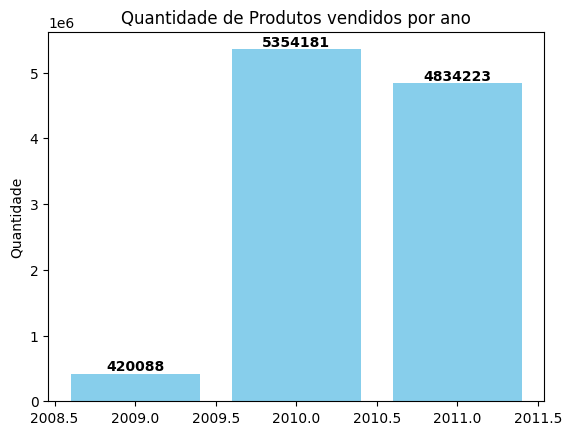

In [32]:
# plt.figure(figsize=(3, 3))
# plt.plot(transactions_by_year['ano'], transactions_by_year['Quantity'], marker='o', linestyle='-')
# plt.xlabel('Data')
# plt.ylabel('Quantidade')
# plt.title('Quantidades vendidas por ano')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.show()
# transactions[['ano', 'Price']].boxplot(by='ano', figsize=(3,3))
# transactions[['ano', 'Quantity']].plot(kind='bar', figsize=(3,3), legend=True, label='Teste')

print(transactions_by_year['ano'])

# Criar o gráfico de barras
fig, ax = plt.subplots()
barras = ax.bar(transactions_by_year['ano'], transactions_by_year['Quantity'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de Produtos vendidos por ano')

# Mostrar o gráfico
plt.show()

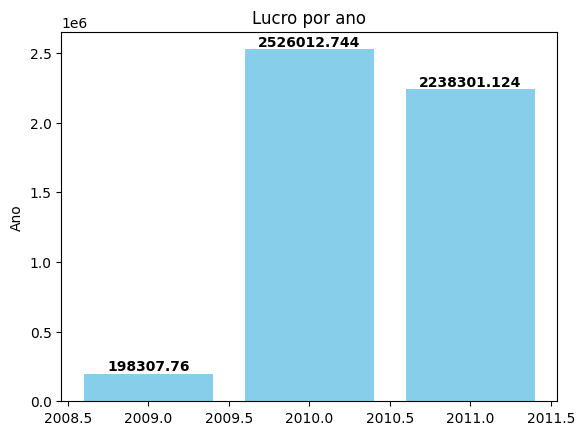

In [ ]:
# Total de vendas por ano
prices_by_year = transactions_filtered.groupby('ano', as_index=False)['Price'].sum()

fig, ax = plt.subplots()
barras = ax.bar(prices_by_year['ano'], prices_by_year['Price'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Ano')
ax.set_title('Lucro por ano')

# Mostrar o gráfico
plt.show()

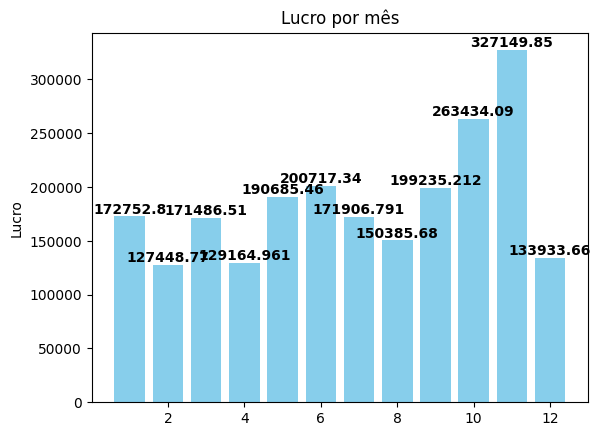

In [41]:
# Total de vendas por mês
# prices_by_month = transactions_filtered.groupby('mes', as_index=False)['Price'].sum()
prices_by_month = transactions_filtered.groupby(['ano', 'mes'], as_index=False).agg({'Price': 'sum'})

prices_by_month_filtered = prices_by_month.loc[prices_by_month['ano'] == 2011]

# Criar o gráfico de barras
fig, ax = plt.subplots()
barras = ax.bar(prices_by_month_filtered['mes'], prices_by_month_filtered['Price'], color='skyblue')

# Adicionar os valores nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura, 
            f'{altura}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurar rótulos e título
ax.set_ylabel('Lucro')
ax.set_title('Lucro por mês')

# Mostrar o gráfico
plt.show()

# TODO Futuras implementações

In [35]:
# Coisas que podemos fazer
# Comparar datas da primeira compra até a compra mais recente
# df['rental_days'] = df[['rental_date', 'return_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)
# Usar bokeh

In [36]:
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook